**Algoritmo de Agrupamento Kmeans**

**Código baseado em:**

1) https://www.kaggle.com/code/khotijahs1/k-means-clustering-of-iris-dataset

2) https://realpython.com/k-means-clustering-python/

In [57]:
!pip install plotly --upgrade
%pip install kneed
%pip install minisom

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for minisom: filename=minisom-2.3.5-py3-none-any.whl size=12133 sha256=47beeeab19ac3019cb4fec386875998aef92bcf7a5e603075fde197585a1fca2
  Stored in directory: c:\users\angelo.marques\appdata\local\pip\cache\wheels\df\bc\51\5a64336510519dc8062d6e17d458721906b85b09abe192481e
Successfully built minisom
Note: you may need to restart the kernel to use updated packages.


In [58]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans #Importando a função Kmeans
from sklearn.preprocessing import StandardScaler #Função utilizada para normalização dos dados
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler #Função utilizada para normalização dos dados
from kneed import KneeLocator
import pandas as pd
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import DBSCAN
from minisom import MiniSom
import numpy as np


In [59]:
import pandas as pd
base= pd.read_csv('Iris.csv', sep=';')
base

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
141,6.7,3.0,5.2,2.3,Iris-virginica
142,6.3,2.5,5.0,1.9,Iris-virginica
143,6.5,3.0,5.2,2.0,Iris-virginica
144,6.2,3.4,5.4,2.3,Iris-virginica


In [60]:
columns = base.columns[0:4]

In [61]:
# Função para remover outliers usando IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df


df_clean = remove_outliers(base, columns)
print(f"Original shape: {base.shape}, Cleaned shape: {df_clean.shape}")
base = df_clean

Original shape: (146, 5), Cleaned shape: (146, 5)


In [62]:
import numpy as np
from scipy.spatial.distance import cdist

def dunn_index(X, labels):
    clusters = np.unique(labels)
    min_intercluster = np.inf
    max_intracluster = 0

    # Calcular distância mínima entre clusters
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            points_cluster_i = X[labels == clusters[i]]
            points_cluster_j = X[labels == clusters[j]]
            distances = cdist(points_cluster_i, points_cluster_j)
            min_distance = np.min(distances)
            if min_distance < min_intercluster:
                min_intercluster = min_distance

    # Calcular diâmetro máximo dentro dos clusters
    for cluster in clusters:
        points = X[labels == cluster]
        if len(points) > 1:
            distances = cdist(points, points)
            max_distance = np.max(distances)
            if max_distance > max_intracluster:
                max_intracluster = max_distance

    # Índice de Dunn
    return min_intercluster / max_intracluster


In [63]:
Entrada = base.iloc[:, 0:4].values
Entrada.shape

(146, 4)

In [64]:
#scaler = StandardScaler()
scaler = MinMaxScaler()
Entrada = scaler.fit_transform(Entrada)

In [65]:
Entrada

array([[0.22222222, 0.72222222, 0.06779661, 0.04166667],
       [0.16666667, 0.44444444, 0.06779661, 0.04166667],
       [0.11111111, 0.55555556, 0.05084746, 0.04166667],
       [0.08333333, 0.5       , 0.08474576, 0.04166667],
       [0.19444444, 0.77777778, 0.06779661, 0.04166667],
       [0.30555556, 0.94444444, 0.11864407, 0.125     ],
       [0.08333333, 0.66666667, 0.06779661, 0.08333333],
       [0.19444444, 0.66666667, 0.08474576, 0.04166667],
       [0.02777778, 0.38888889, 0.06779661, 0.04166667],
       [0.16666667, 0.5       , 0.08474576, 0.        ],
       [0.30555556, 0.83333333, 0.08474576, 0.04166667],
       [0.13888889, 0.66666667, 0.10169492, 0.04166667],
       [0.13888889, 0.44444444, 0.06779661, 0.        ],
       [0.        , 0.44444444, 0.01694915, 0.        ],
       [0.41666667, 1.        , 0.03389831, 0.04166667],
       [0.30555556, 0.94444444, 0.05084746, 0.125     ],
       [0.22222222, 0.72222222, 0.06779661, 0.08333333],
       [0.38888889, 0.88888889,

Para analisar Silhouette:
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [66]:
# Determinando a Silhouette para número máximo de cluster estimado (Raiz(instâncias/2)
limit = int((Entrada.shape[0]//2)**0.5)
for k in range(2, limit+1):
    model = KMeans(n_clusters=k)
    model.fit(Entrada)
    pred = model.predict(Entrada)
    score = silhouette_score(Entrada, pred)
    print('Silhouette Score k = {}: {:<.3f}'.format(k, score))

Silhouette Score k = 2: 0.618
Silhouette Score k = 3: 0.478
Silhouette Score k = 4: 0.432
Silhouette Score k = 5: 0.360
Silhouette Score k = 6: 0.379
Silhouette Score k = 7: 0.300
Silhouette Score k = 8: 0.315


**WCSS - Within Clusters Sum of Squares = é a soma dos quadrados dentro dos clusters**
https://rpubs.com/diascodes/770518

Veja: https://en.wikipedia.org/wiki/Elbow_method_(clustering)

In [67]:
wcss = []
for i in range(2, 11):
  #print(i)
  kmeans = KMeans(n_clusters=i, random_state=10)
  kmeans.fit(Entrada)
  wcss.append(kmeans.inertia_)

**Usando o método Elbow para encontrar o número ideal de clusters**

In [68]:
wcss

[13.346128868470906,
 7.999186906126225,
 6.437940996517078,
 6.021093626130889,
 5.1993771005474265,
 4.965741105215714,
 4.562148938896034,
 4.097802081868766,
 2.9475555499496684]

**Vamos analisar o ponto de inflexão dessa curva?**

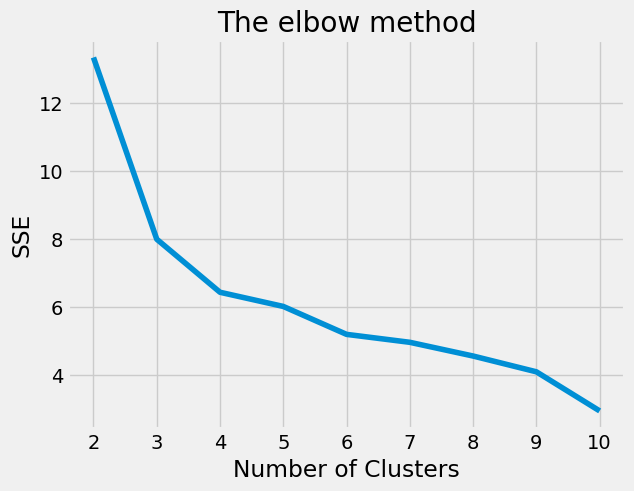

In [69]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), wcss)
plt.xticks(range(2, 11))
plt.title('The elbow method')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [70]:
kl = KneeLocator(range(2, 11), wcss, curve="convex", direction="decreasing")
kl.elbow

np.int64(4)

In [71]:
#K-means++ é um método de otimização de centroide para ajudar o modelo a convergir mais rapidamente
kmeans = KMeans(n_clusters=3, random_state=0)
#kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
saida_kmeans = kmeans.fit_predict(Entrada)

base_numerica = base.iloc[:, :-1]   # 👈 pega todas as colunas menos a última

base_numerica = base_numerica.astype(float)

dunn = dunn_index(base_numerica, saida_kmeans)
print(f"Dunn Index: {dunn:.4f}")

score_ch = calinski_harabasz_score(base_numerica, saida_kmeans)
print(f"Índice de Calinski-Harabasz: {score_ch:.2f}")

Dunn Index: 0.0944
Índice de Calinski-Harabasz: 549.77


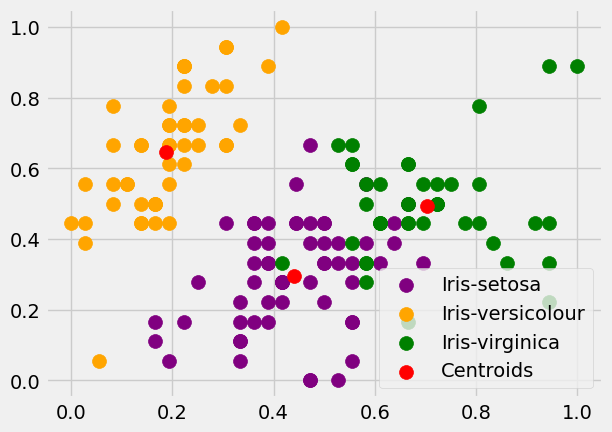

In [72]:
#Visualising the clusters
plt.scatter(Entrada[saida_kmeans == 0, 0], Entrada[saida_kmeans == 0, 1], s = 100, c = 'purple', label = 'Iris-setosa')
plt.scatter(Entrada[saida_kmeans == 1, 0], Entrada[saida_kmeans == 1, 1], s = 100, c = 'orange', label = 'Iris-versicolour')
plt.scatter(Entrada[saida_kmeans == 2, 0], Entrada[saida_kmeans == 2, 1], s = 100, c = 'green', label = 'Iris-virginica')
#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = 'red', label = 'Centroids')
plt.legend()

In [73]:

# Dados já pré-processados do notebook
X = Entrada  # Dados normalizados

# 1. DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

# 2. SOM
# Definir o tamanho do mapa (usando 3 clusters como no K-means)
som = MiniSom(1, 3, X.shape[1], sigma=0.5, learning_rate=0.5)
som.train_random(X, 100)
som_labels = np.array([som.winner(x)[1] for x in X])

# Métricas de avaliação
def evaluate_clusters(X, labels):
    if len(np.unique(labels)) > 1:  # Silhouette não funciona com 1 cluster
        silhouette = silhouette_score(X, labels)
    else:
        silhouette = -1
    if len(np.unique(labels)) > 1:  # Calinski-Harabasz precisa de mais de 1 cluster
        ch_score = calinski_harabasz_score(X, labels)
    else:
        ch_score = -1
    dunn = dunn_index(X, labels)
    return silhouette, ch_score, dunn

# Avaliação dos algoritmos
print("K-means:")
print("Número de clusters:", len(np.unique(saida_kmeans)))
print("Métricas (Silhouette, Calinski-Harabasz, Dunn):", evaluate_clusters(X, saida_kmeans))

print("\nDBSCAN:")
print("Número de clusters:", len(np.unique(dbscan_labels)))
print("Métricas (Silhouette, Calinski-Harabasz, Dunn):", evaluate_clusters(X, dbscan_labels))

print("\nSOM:")
print("Número de clusters:", len(np.unique(som_labels)))
print("Métricas (Silhouette, Calinski-Harabasz, Dunn):", evaluate_clusters(X, som_labels))

K-means:
Número de clusters: 3
Métricas (Silhouette, Calinski-Harabasz, Dunn): (np.float64(0.4823988251858557), np.float64(305.1699466116371), np.float64(0.06495106259798489))

DBSCAN:
Número de clusters: 1
Métricas (Silhouette, Calinski-Harabasz, Dunn): (-1, -1, np.float64(inf))

SOM:
Número de clusters: 3
Métricas (Silhouette, Calinski-Harabasz, Dunn): (np.float64(0.5427749609410009), np.float64(161.08813975213687), np.float64(0.24887354882431154))


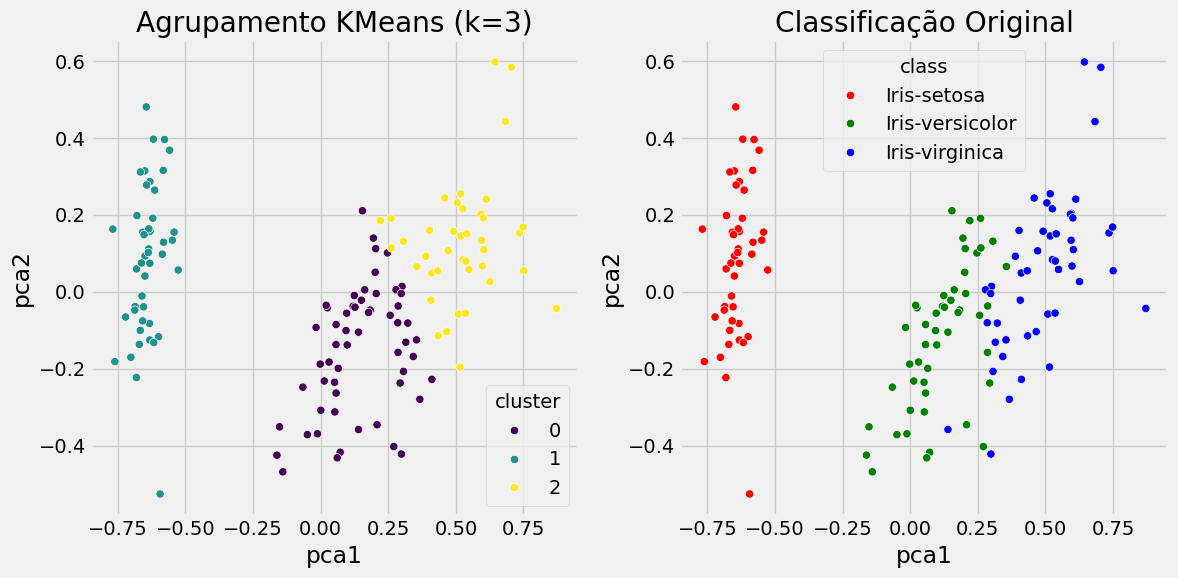


Instâncias classificadas incorretamente: 110
cluster           0   1   2
class                      
Iris-setosa       0  47   0
Iris-versicolor  44   0   5
Iris-virginica   14   0  36


In [74]:
# Adicionar os rótulos dos clusters ao DataFrame
base['cluster'] = saida_kmeans

# Redução de dimensionalidade com PCA (2 componentes)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
Entrada_pca = pca.fit_transform(Entrada)
base['pca1'] = Entrada_pca[:, 0]
base['pca2'] = Entrada_pca[:, 1]

# Mapear classes reais para cores/marcadores
class_mapping = {
    'Iris-setosa': 'red',
    'Iris-versicolor': 'green',
    'Iris-virginica': 'blue'
}

# Plotar clusters vs classes reais
plt.figure(figsize=(12, 6))

# Subplot 1: Clusters do KMeans
plt.subplot(1, 2, 1)
sns.scatterplot(data=base, x='pca1', y='pca2', hue='cluster', palette='viridis')
plt.title('Agrupamento KMeans (k=3)')

# Subplot 2: Classes Originais
plt.subplot(1, 2, 2)
sns.scatterplot(data=base, x='pca1', y='pca2', hue='class', palette=class_mapping)
plt.title('Classificação Original')

plt.tight_layout()
plt.show()

# Identificar instâncias classificadas incorretamente
misclassified = base[base['class'].map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}) != base['cluster']]
print(f"\nInstâncias classificadas incorretamente: {len(misclassified)}")
print(pd.crosstab(base['class'], base['cluster']))